
# Detección del Estado de Ánimo en Gatos mediante Imágenes (Gatección)

El problema a resolver en este proyecto es la detección automática del estado de ánimo en gatos a partir de imágenes. Los gatos suelen tener señales emocionales sutiles, expresadas a través de pequeñas variaciones en su rostro y postura corporal. 

Para entrenar el modelo se utilizarán dos conjuntos de datos: el Cat Faces Dataset, disponible en https://www.kaggle.com/datasets/crawford/cat-dataset, el Animal Faces HQ AFHQ, accesible https://www.kaggle.com/datasets/andrewmvd/animal-faces y el The Oxford-IIIT Pet Dataset, disponible en https://www.robots.ox.ac.uk/~vgg/data/pets/ . Las fuentes contienen miles de imágenes de gatos con variabilidad en ángulos, expresiones y poses. Aunque no incluyen etiquetas emocionales explícitas, se aplicará un proceso de etiquetado manual, basado en criterios etológicos como posición de orejas, ojos, bigotes y tensión corporal.

La solución propuesta consiste en entrenar una red neuronal convolucional (CNN), compuesta por capas convolucionales, de agrupamiento pooling y densas, finalizando en una capa softmax que clasifique los estados emocionales (relajado, alerta, estresado, molesto). 

In [14]:
import os
import torch.nn 
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [15]:
# ================================================================
# 0) Rutas de los DOS conjuntos ya separados
#     • Train  : archive/data/labeled/conjunto2/<clase>/*.jpg
#     • Val    : archive/data/labeled/conjunto-pruebas/<clase>/*.jpg
# ================================================================
import os
from glob import glob

base_dir   = os.getcwd()
train_root = os.path.join(base_dir, "archive", "data", "labeled", "conjunto2")
val_root   = os.path.join(base_dir, "archive", "data", "labeled", "conjunto-pruebas")

# ----------------------------------------------------------------
# 1) Mapa de etiquetas  (¡mismo orden que usaste al ENTRENAR el modelo!)
# ----------------------------------------------------------------
label_map = {
    "alerta":  0,
    "dormido": 1,
    "enojado": 2,   # ← índice 2
    "neutral": 3,   # ← índice 3
}

# ----------------------------------------------------------------
# 2) Función auxiliar
# ----------------------------------------------------------------
def recolectar_imagenes(root_dir: str, label_map: dict):
    """
    Recorre root_dir/<clase>/*.{jpg,png,jpeg}
    y devuelve dos listas paralelas (paths, labels).
    """
    paths, labels = [], []
    for clase, idx in label_map.items():
        carpeta = os.path.join(root_dir, clase)
        if not os.path.isdir(carpeta):
            raise FileNotFoundError(f"[ERROR] Falta carpeta: {carpeta}")
        for ruta in glob(os.path.join(carpeta, "*")):
            if ruta.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(ruta)
                labels.append(idx)
    return paths, labels

# ----------------------------------------------------------------
# 3) Recolectar imágenes de train y val (sin train_test_split)
# ----------------------------------------------------------------
train_paths, train_labels = recolectar_imagenes(train_root, label_map)
val_paths,   val_labels   = recolectar_imagenes(val_root,   label_map)

print(f"Imágenes de entrenamiento: {len(train_paths)}")
print(f"Imágenes   de validación: {len(val_paths)}")

# Mostrar un ejemplo para verificar
print("Ejemplo train:", train_paths[0], "→ label", train_labels[0])
print("Ejemplo val:  ", val_paths[0],   "→ label", val_labels[0])

# Ahora:  train_paths / train_labels
#         val_paths   / val_labels
# están listos para crear tus Datasets / DataLoaders


Imágenes de entrenamiento: 219
Imágenes   de validación: 35
Ejemplo train: /home/marcat/Redes Neuronales 2025/Proyecto-RN/proyecto2/Proyecto-RN/archive/data/labeled/conjunto2/alerta/00000055_003.jpg → label 0
Ejemplo val:   /home/marcat/Redes Neuronales 2025/Proyecto-RN/proyecto2/Proyecto-RN/archive/data/labeled/conjunto-pruebas/alerta/images (copia 2).jpg → label 0


In [16]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch

# ================================================================
# 3) Dataset personalizado
#    (ahora admite las 4 nuevas clases: alerta, dormido, enojado, neutral)
# ================================================================
class CatsEmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Parameters
        ----------
        image_paths : list[str]
            Rutas absolutas a las imágenes.
        labels : list[int]
            Enteros 0..3 que corresponden a:
                0 → alerta
                1 → dormido
                2 → enojado
                3 → neutral
        transform : torchvision.transforms
            Transformaciones a aplicar (resize, normalización, …).
        """
        assert len(image_paths) == len(labels), "Rutas y labels deben tener la misma longitud"
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")          # → tensor [3,H,W]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# ================================================================
# 4) Transformaciones
#    — mantengo 64×64 para compatibilidad con la CNN simple
#      (cámbialo a 224×224 si usas ResNet preentrenada)
# ================================================================
train_transforms = T.Compose([
    T.Resize((64, 64)),          # cambio aquí si tu modelo necesita otra resolución
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

# ================================================================
# 5) Instancias de Dataset (train / val)
# ================================================================
train_dataset = CatsEmotionDataset(train_paths, train_labels, transform=train_transforms)
val_dataset   = CatsEmotionDataset(val_paths,   val_labels,   transform=val_transforms)

print(f"Imágenes de entrenamiento: {len(train_dataset)}")
print(f"Imágenes de validación:   {len(val_dataset)}")

# ================================================================
# 6) DataLoaders
# ================================================================
BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"Batches en train_loader: {len(train_loader)}")
print(f"Batches en val_loader:   {len(val_loader)}")

# ================================================================
# 7) Verificación rápida
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imgs_batch, labels_batch = next(iter(train_loader))
print("\nBatch de train_loader:")
print("  images.shape:", imgs_batch.shape)   # (BATCH_SIZE, 3, 64, 64)
print("  labels.shape:", labels_batch.shape) # (BATCH_SIZE,)

# Mover a GPU (si está disponible)
imgs_batch  = imgs_batch.to(device)
labels_batch = labels_batch.to(device)
print("  images device:", imgs_batch.device)
print("  labels device:", labels_batch.device)


Imágenes de entrenamiento: 219
Imágenes de validación:   35
Batches en train_loader: 55
Batches en val_loader:   9

Batch de train_loader:
  images.shape: torch.Size([4, 3, 64, 64])
  labels.shape: torch.Size([4])
  images device: cpu
  labels device: cpu


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

###############################################################################
#  CatMoodNET  (versión 4-clases: alerta · dormido · enojado · neutral)
#  --------------------------------------------------------------------------
#  Entrada : tensor   (batch, 3, 64, 64)
#  Salida  : logits   (batch, 4)     # índices:
#                                      0 → alerta
#                                      1 → dormido
#                                      2 → enojado
#                                      3 → neutral
#
#  Arquitectura:
#    Conv2d(3  → 64, 5×5)  + ReLU + MaxPool2d(2)     → (batch, 64, 30, 30)
#    Conv2d(64 → 32, 5×5)  + ReLU + MaxPool2d(2)     → (batch, 32, 13, 13)
#    Flatten (32·13·13 = 5 408)
#    Linear(5 408 → 384) + ReLU
#    Linear(384   → 192) + ReLU
#    Linear(192   → n_classes)   (*CrossEntropyLoss* aplica Softmax)
###############################################################################

class CatMoodNET(nn.Module):
    def __init__(self, n_classes: int = 4):
        """
        n_classes = 4 porque ahora las carpetas son:
        ['alerta', 'dormido', 'enojado', 'neutral']
        """
        super().__init__()

        # Bloque convolucional 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)       # 3 canales RGB
        # Bloque convolucional 2
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5)

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(32 * 13 * 13, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, n_classes)

    # ------------------------------------------------------------------
    def forward(self, x):
        # Conv1 → ReLU → MaxPool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Conv2 → ReLU → MaxPool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC1 → ReLU
        x = F.relu(self.fc1(x))
        # FC2 → ReLU
        x = F.relu(self.fc2(x))
        # FC3 (logits)
        return self.fc3(x)

    # ------------------------------------------------------------------
    def train_model(
        self,
        epochs: int,
        data_loader,
        val_loader,
        criterion,
        optimizer,
        cuda: bool = False,
    ):
        """
        Entrena la red y evalúa en validación al final de cada época.
        """
        device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
        self.to(device)

        loss_vals, val_acc_vals = [], []

        for ep in range(1, epochs + 1):
            # ---------------- Entrenamiento ----------------
            self.train()
            tr_loss, tr_corr, tr_total = 0.0, 0, 0

            for imgs, lbls in data_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                out = self(imgs)
                loss = criterion(out, lbls)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * imgs.size(0)
                tr_corr += (out.argmax(1) == lbls).sum().item()
                tr_total += imgs.size(0)

            loss_epoch = tr_loss / tr_total
            acc_epoch  = tr_corr / tr_total
            loss_vals.append(loss_epoch)

            # ---------------- Validación ----------------
            self.eval()
            v_corr, v_tot = 0, 0
            with torch.no_grad():
                for imgs, lbls in val_loader:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    out = self(imgs)
                    v_corr += (out.argmax(1) == lbls).sum().item()
                    v_tot  += lbls.size(0)
            val_acc = v_corr / v_tot
            val_acc_vals.append(val_acc)

            print(f"Ép {ep:02}/{epochs} | "
                  f"Train Loss {loss_epoch:.4f} | Train Acc {acc_epoch:.4f} | "
                  f"Val Acc {val_acc:.4f}")

        # ---------------- Gráficas ----------------
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), loss_vals, marker='o')
        plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Pérdida")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), val_acc_vals, marker='o', color='orange')
        plt.xlabel("Época"); plt.ylabel("Val Accuracy"); plt.title("Accuracy")
        plt.grid(True)

        plt.tight_layout(); plt.show()


Entrenamiento en CPU.
Ép 01/40 | Train Loss 1.3929 | Train Acc 0.2511 | Val Acc 0.2857
Ép 02/40 | Train Loss 1.3911 | Train Acc 0.2557 | Val Acc 0.2286
Ép 03/40 | Train Loss 1.3772 | Train Acc 0.2785 | Val Acc 0.2571
Ép 04/40 | Train Loss 1.3682 | Train Acc 0.3014 | Val Acc 0.3143
Ép 05/40 | Train Loss 1.3656 | Train Acc 0.3379 | Val Acc 0.3429
Ép 06/40 | Train Loss 1.3354 | Train Acc 0.3516 | Val Acc 0.3429
Ép 07/40 | Train Loss 1.3046 | Train Acc 0.3790 | Val Acc 0.3429
Ép 08/40 | Train Loss 1.2346 | Train Acc 0.4658 | Val Acc 0.3429
Ép 09/40 | Train Loss 1.2395 | Train Acc 0.4429 | Val Acc 0.4000
Ép 10/40 | Train Loss 1.1662 | Train Acc 0.4932 | Val Acc 0.3143
Ép 11/40 | Train Loss 1.0937 | Train Acc 0.5571 | Val Acc 0.3429
Ép 12/40 | Train Loss 1.0420 | Train Acc 0.5388 | Val Acc 0.3714
Ép 13/40 | Train Loss 0.9859 | Train Acc 0.5479 | Val Acc 0.3714
Ép 14/40 | Train Loss 0.9297 | Train Acc 0.5936 | Val Acc 0.4000
Ép 15/40 | Train Loss 0.8409 | Train Acc 0.6347 | Val Acc 0.4857
Ép 

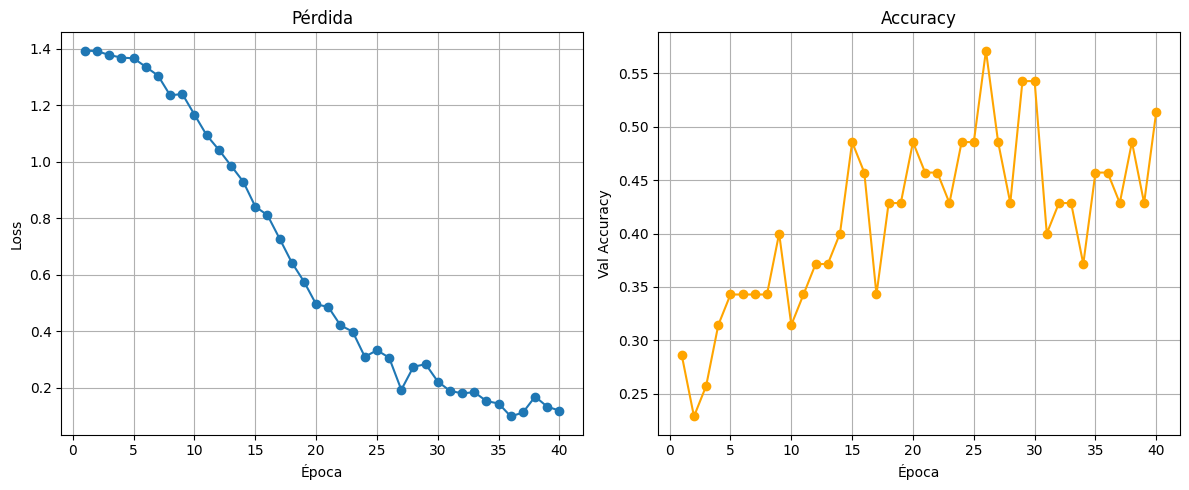

In [18]:
import torch.optim as optim

# 1) Instanciamos la red CatMoodNET  y la llevamos a GPU si está disponible
model = CatMoodNET(n_classes=4)

cuda = True
if cuda and torch.cuda.is_available():
    model = model.to('cuda')
    print("Se usará GPU para el entrenamiento.")
else:
    print("Entrenamiento en CPU.")

# 2) Definimos el criterio y el optimizador
criterio = nn.CrossEntropyLoss()
optimizador = optim.Adam(model.parameters(), lr=1e-4)

# 3) Llamamos a train_model, pasándole también el val_loader para validación en cada época
model.train_model(
    epochs=40,
    data_loader=train_loader,   # DataLoader de entrenamiento
    val_loader=val_loader,      # DataLoader de validación
    criterion=criterio,
    optimizer=optimizador,
    cuda=cuda
)


In [19]:
# ================================================================
# 1) Funciones de conteo y precisión global
#    (válidas para las NUEVAS clases:
#        0 → alerta · 1 → dormido · 2 → enojado · 3 → neutral)
# ================================================================
import torch

def contarCorrectas(net, batch, labels, func=None):
    """
    Devuelve cuántas predicciones del lote son correctas.
    Si se pasa `func`, primero transforma el batch (p.ej. horizontal flip).
    """
    if func is not None:
        batch = func(batch)
    salidas = net(batch)                    # logits  [batch, n_classes]
    preds   = salidas.argmax(dim=1)         # índice de clase ganadora
    return (preds == labels).sum()          # escalar (tensor)

def calcularPrecisionGlobal(net, data_loader, func=None, cuda=False):
    """
    Calcula accuracy (%) de `net` sobre todo el `data_loader`.
    - Usa net.eval() y no actualiza gradientes.
    - Denominador = nº real de muestras (len(dataset)), evita sesgo del último batch.
    """
    device = next(net.parameters()).device
    net.eval()

    correctas = 0
    total     = 0
    with torch.no_grad():
        for images, labels in data_loader:
            if cuda and torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            correctas += contarCorrectas(net, images, labels, func).item()
            total     += labels.size(0)

    return 100 * correctas / total   # porcentaje


# ================================================================
# 2) Ejemplo de uso
# ================================================================
# model = CatMoodNET(n_classes=4).to(device)          # 0-alerta … 3-neutral
# train_loader = ...
# val_loader   = ...
# cuda = True

prec_train = calcularPrecisionGlobal(model, train_loader, cuda=cuda)
prec_val   = calcularPrecisionGlobal(model, val_loader,   cuda=cuda)

print(f"Precisión en entrenamiento: {prec_train:.2f}%")
print(f"Precisión en validación:   {prec_val:.2f}%")

# Guardar pesos
torch.save(model.state_dict(), "CatMoodNET_model.pth")


Precisión en entrenamiento: 96.80%
Precisión en validación:   51.43%


In [20]:
# a) ¿Qué clases únicas hay en train / val?
print("Etiquetas únicas en train_labels :", sorted(set(train_labels)))
print("Etiquetas únicas en val_labels   :", sorted(set(val_labels)))

# b) Dict (label -> nº de imágenes) para ver si está balanceado
from collections import Counter
print("Count train :", Counter(train_labels))
print("Count val   :", Counter(val_labels))


Etiquetas únicas en train_labels : [0, 1, 2, 3]
Etiquetas únicas en val_labels   : [0, 1, 2, 3]
Count train : Counter({0: 58, 2: 58, 1: 56, 3: 47})
Count val   : Counter({0: 10, 2: 10, 1: 9, 3: 6})


In [21]:
# -----------------------------------
# Cargar el modelo entrenado forzando uso de CPU
# -----------------------------------
model = CatMoodNET(n_classes=4)

# Cargar pesos siempre en CPU
model.load_state_dict(torch.load('CatMoodNET_model.pth', map_location=torch.device('cpu')))

# Asegurarse de que el modelo esté en CPU
model = model.to('cpu')
print("Modelo cargado en CPU.")


Modelo cargado en CPU.


Modelo cargado en CPU.


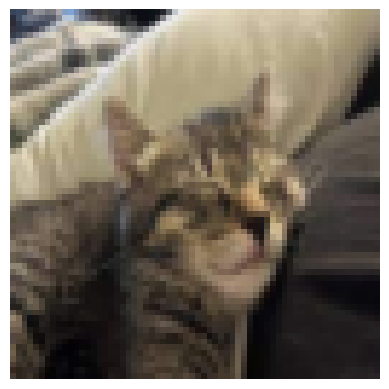

Etiqueta real:      dormido
Predicción de la red: dormido
----------------------------------------


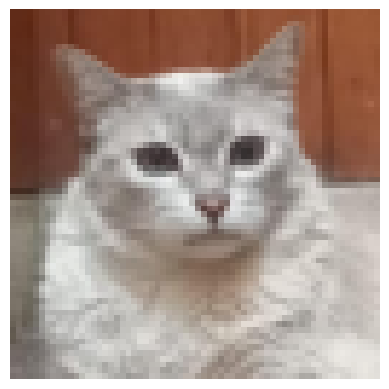

Etiqueta real:      neutral
Predicción de la red: neutral
----------------------------------------


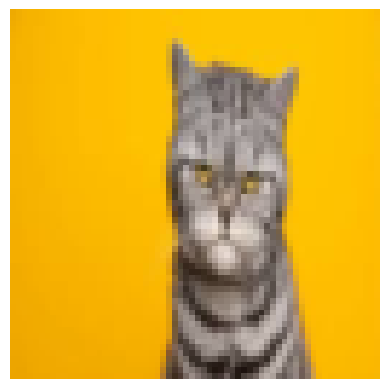

Etiqueta real:      enojado
Predicción de la red: enojado
----------------------------------------


In [48]:
import random, torch, matplotlib.pyplot as plt, numpy as np

# ----------------------------------------------------------------
# 1) NUEVAS clases de estado de ánimo
# ----------------------------------------------------------------
classes = ('alerta', 'dormido', 'enojado', 'neutral')

# ----------------------------------------------------------------
# 2) Desnormalizar y mostrar una imagen tensorial
# ----------------------------------------------------------------
def mostrarImagen(imagen):
    """
    Imagen tensor → RGB “normal” (mean/std de ImageNet) y plotea.
    """
    imagen = imagen.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = imagen * std + mean          # desnormaliza
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

# ----------------------------------------------------------------
# 3) Predecir y mostrar una imagen aleatoria de un Dataset
# ----------------------------------------------------------------
def predecirImagenAleatoria(modelo, dataset):
    """
    Selecciona una imagen aleatoria del dataset, la muestra y 
    escribe etiqueta real + predicción.
    """
    idx = random.randint(0, len(dataset) - 1)
    imagen, etiqueta_real = dataset[idx]

    mostrarImagen(imagen)

    modelo.eval()
    with torch.no_grad():
        logits = modelo(imagen.unsqueeze(0))          # [1,4]
        pred   = logits.argmax(1).item()

    print(f"Etiqueta real:      {classes[etiqueta_real]}")
    print(f"Predicción de la red: {classes[pred]}")

# ----------------------------------------------------------------
# 4) Cargar el modelo (CPU forzado)
# ----------------------------------------------------------------
model = CatMoodNET(n_classes=4)
model.load_state_dict(torch.load("CatMoodNET_model.pth",
                                 map_location=torch.device('cpu')))
model = model.to('cpu')
print("Modelo cargado en CPU.")

# ----------------------------------------------------------------
# 5) Dataset de validación ya creado (val_dataset)
# ----------------------------------------------------------------
dataset_prueba = val_dataset    # asegúrate de haberlo inicializado antes

# ----------------------------------------------------------------
# 6) Mostrar 3 imágenes aleatorias + predicción
# ----------------------------------------------------------------
for _ in range(3):
    predecirImagenAleatoria(model, dataset_prueba)
    print("-" * 40)


Modelo cargado en CPU.


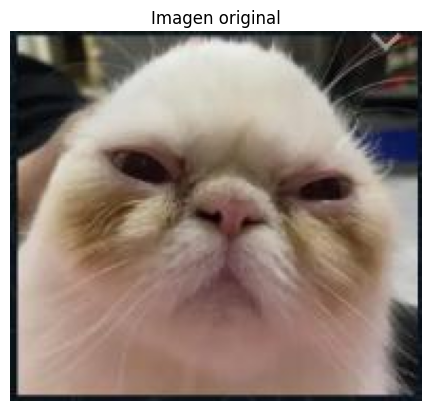

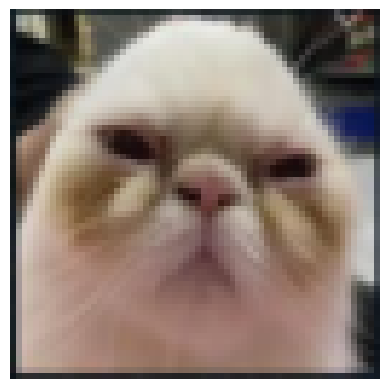

Predicción: enojado


In [23]:
# ----------------------------------------------------------------
# 0) Transformación a aplicar a la imagen “suelta”
#     — reutilizamos la misma de validación (val_transforms)
# ----------------------------------------------------------------
single_img_transform = val_transforms   # mismo resize(128,128)+ToTensor+Normalize

# ----------------------------------------------------------------
# 1) Función para predecir a partir de la ruta de un archivo
# ----------------------------------------------------------------
from PIL import Image
def predecirImagen(ruta_img, modelo, transform, classes):
    """
    - ruta_img : str  → ruta absoluta o relativa a la imagen (p. ej. 'gatito.jpg')
    - modelo   : red entrenada (ya en eval y en CPU o GPU)
    - transform: transformaciones (Resize, ToTensor, Normalize)
    - classes  : tupla/lista con nombres de clase
    """
    # 1. Cargar imagen con PIL y forzar RGB
    img_pil = Image.open(ruta_img).convert("RGB")
    
    # 2. Mostrar la imagen original
    plt.figure(); plt.imshow(img_pil); plt.axis('off'); plt.title("Imagen original"); plt.show()

    # 3. Aplicar transformaciones → tensor [3, H, W]
    img_tensor = transform(img_pil)

    # 4. Desnormalizar para visualizar la entrada al modelo (opcional)
    mostrarImagen(img_tensor)   # usa la función definida antes

    # 5. Pasar al modelo
    modelo.eval()
    with torch.no_grad():
        salida = modelo(img_tensor.unsqueeze(0))   # [1, n_classes]
        _, pred = torch.max(salida, 1)

    # 6. Imprimir resultado
    print(f"Predicción: {classes[pred.item()]}")

# ----------------------------------------------------------------
# 2) Cargar/asegurar modelo en CPU
# ----------------------------------------------------------------
model = CatMoodNET(n_classes=4)
model.load_state_dict(torch.load('CatMoodNET_model.pth', map_location=torch.device('cpu')))
model = model.to('cpu')
print("Modelo cargado en CPU.")

# ----------------------------------------------------------------
# 3) Predecir una imagen suelta
# ----------------------------------------------------------------
ruta_imagen = "pruebas/gatito2.jpg"   # cambia esto a la ruta real
predecirImagen(ruta_imagen, model, single_img_transform, classes)
